In [6]:
import requests
import json

# Endpoint URL
url = 'https://apps.fs.usda.gov/arcx/rest/services/EDW/EDW_TimberAppraisalZones_01/MapServer/1/query'

# Specify the fields to retrieve, excluding large fields
desired_fields = 'OBJECTID,APPRAISALZONE,FORESTCOUNT,RANGERDISTRICTCOUNT,GIS_ACRES'

# Common parameters for all requests
params = {
    'where': '1=1',
    'outFields': desired_fields,  # You can specify fields like 'OBJECTID,APPRAISALZONE,FORESTCOUNT'
    'f': 'geojson',
    'resultRecordCount': 10  # Maximum records per request
}

# Parameters for the count query
count_params = {
    'where': '1=1',
    'returnCountOnly': 'true',
    'f': 'json'
}

# Send the count request
count_response = requests.get(url, params=count_params)

# Check for server errors
if count_response.status_code != 200:
    print(f"Error fetching total count: {count_response.status_code}")
    total_count = None
else:
    # Parse the count from the response
    total_count = count_response.json().get('count', 0)
    print(f"Total number of features available: {total_count}")


Total number of features available: 88


In [ ]:

# Initialize variables
all_features = []
offset = 0

while True:
    # Update the result offset for pagination
    params['resultOffset'] = offset
    print(f"Fetching records starting from offset {offset}...")
    
    # Send the GET request
    response = requests.get(url, params=params)
    
    # Check for server errors
    if response.status_code != 200:
        print(f"Server returned status code {response.status_code}. Adjusting parameters...")
        # Optionally adjust 'resultRecordCount' or 'outFields' here if needed
        break
    
    # Parse the JSON response
    data = response.json()
    
    # Check if 'features' key exists
    if 'features' not in data or not data['features']:
        print("No more features to fetch.")
        break
    
    # Append the features to the list
    all_features.extend(data['features'])
    
    # Check if we've received fewer features than the maximum per request
    if len(data['features']) < params['resultRecordCount']:
        print("Fetched the last chunk of data.")
        break
    
    # Increment the offset for the next iteration
    offset += params['resultRecordCount']

# Construct the final GeoJSON structure
geojson_data = {
    "type": "FeatureCollection",
    "features": all_features
}

# Save the data to a GeoJSON file
output_filename = 'TimberAppraisalZones.geojson'
with open(output_filename, 'w') as outfile:
    json.dump(geojson_data, outfile)

print(f"Data successfully saved to {output_filename}")

<Axes: >

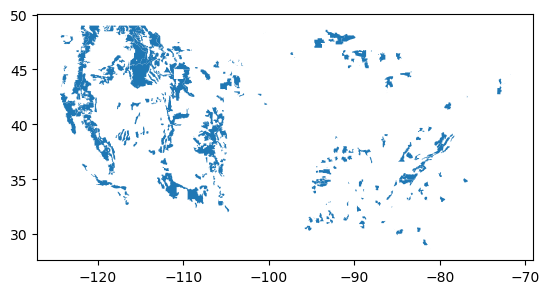

In [5]:
# plot geojson data
import geopandas as gpd

gdf = gpd.read_file(output_filename)
gdf.plot()

In [7]:
gdf.head()

,OBJECTID,APPRAISALZONE,FORESTCOUNT,RANGERDISTRICTCOUNT,GIS_ACRES,geometry
0,89,01001,4,19,1.034091e+07,"MULTIPOLYGON (((-110.94731 45.20169, -110.9473..."
1,90,01002,4,17,8.023132e+06,"MULTIPOLYGON (((-115.05899 47.26985, -115.0643..."
2,91,01003,2,6,3.613478e+06,"MULTIPOLYGON (((-116.37444 48.44430, -116.3689..."
3,92,01004,2,7,4.943385e+06,"MULTIPOLYGON (((-116.03242 47.22439, -116.0377..."
4,93,02001,6,23,1.173429e+07,"MULTIPOLYGON (((-105.68590 40.97139, -105.6811..."


<Axes: >

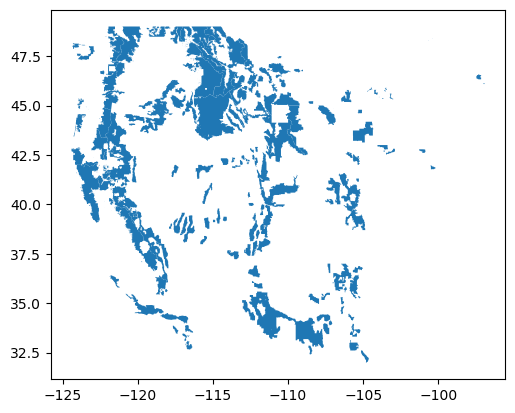

In [28]:
# define a bounding box that covers CA, OR, WA, NV, ID, and CO
bbox = [-124.848974, 31.332177, -109.045223, 49.002494]

# clip the data to the bounding box
gdf_clipped = gdf.cx[bbox[0]:bbox[2], bbox[1]:bbox[3]]

# Plot the clipped data
gdf_clipped.plot()


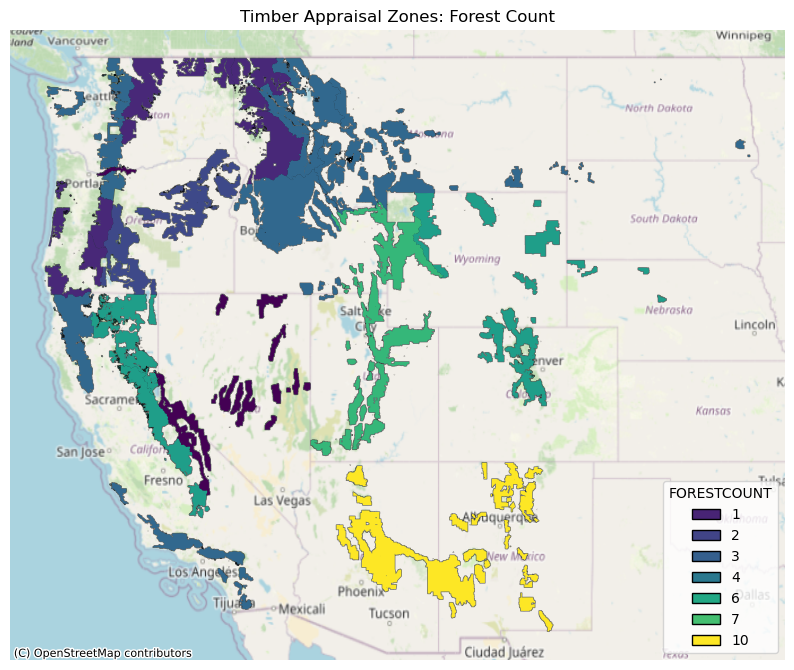

In [32]:
# add a basemap
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Plot the GeoDataFrame
ax = gdf_clipped.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, crs=gdf_clipped.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Fill polygons with a column and add a legend
gdf_clipped.plot(column='FORESTCOUNT', ax=ax, legend=False)

# Add a title
ax.set_title('Timber Appraisal Zones: Forest Count')

# Create custom legend elements
unique_values = gdf_clipped['FORESTCOUNT'].unique()
# sort the values
unique_values = sorted(unique_values)
legend_elements = [Patch(facecolor=plt.cm.viridis(value / max(unique_values)), edgecolor='k', label=f'{value}') for value in unique_values]

# Add the custom legend to the plot
ax.legend(handles=legend_elements, title='FORESTCOUNT', loc='lower right')

# Remove axis
ax.set_axis_off()

# Show the plot
plt.show()

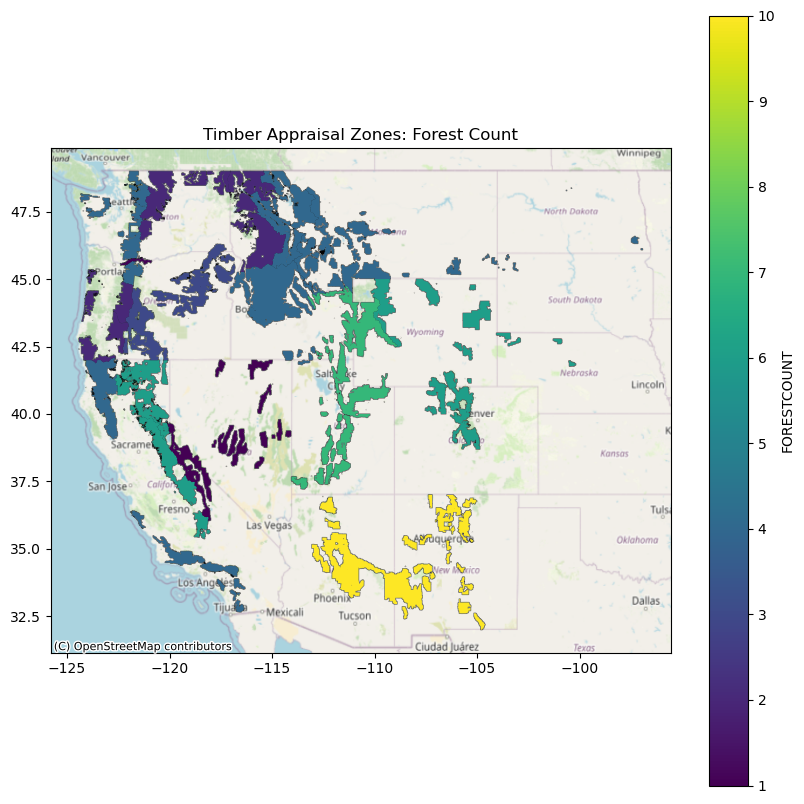

In [29]:
# add a basemap
import contextily as ctx
import matplotlib.pyplot as plt

ax = gdf_clipped.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, crs=gdf_clipped.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# fill polygons
gdf_clipped.plot(column='FORESTCOUNT', ax=ax, legend=True, legend_kwds={'label': "FORESTCOUNT"})

# add a title
ax.set_title('Timber Appraisal Zones: Forest Count')

# change legend to show discreet values
from matplotlib.lines import Line2D


# move legend to bottom right
legend = ax.get_legend()
# legend.set_bbox_to_anchor((1, 0))
# legend.set_loc('lower right')

# remove axis
ax.set_axis_off()

# show the plot

plt.show()